# Ten Years Stroke project

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataframe = pd.read_csv('tenyear_stroke.csv')
dataframe.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
continuous_data = dataframe[['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']]
discrete_data = dataframe[['male','education','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes','TenYearCHD']]

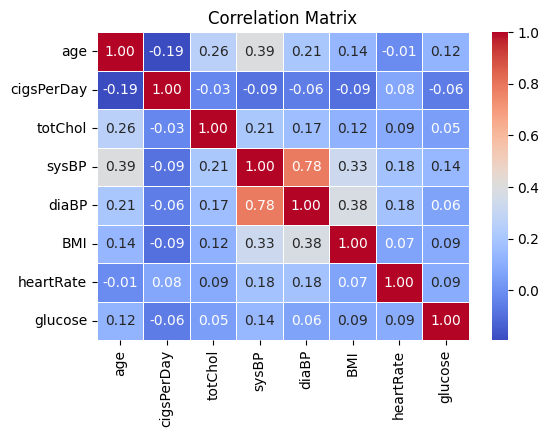

In [5]:
# Step 1: Calculate the correlation matrix
corr_matrix = continuous_data.corr()

# Step 2: Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Step 3: Show the plot
plt.title("Correlation Matrix")
plt.show()


In [18]:
from pgmpy.estimators.CITests import chi_square

print(chi_square(X='age',Y='male', Z=[] ,data= dataframe, significance_level = 0.05))

True


# Detect outliers and filter the space



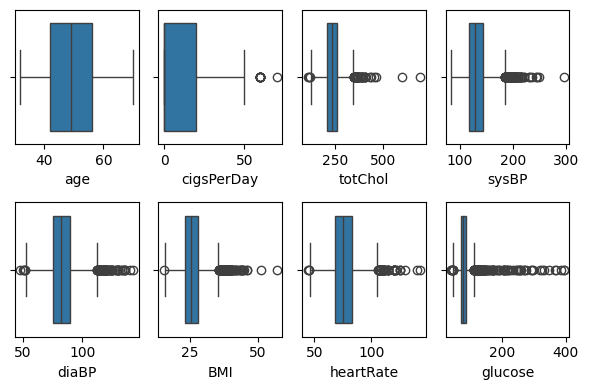

In [56]:
# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 4, figsize=(6, 4))  # Adjust size for better spacing

# Flatten the 2D array of axes to make indexing easier
axes = axes.flatten()
features = continuous_data.columns
# Plot a box plot for each feature
for i, feature in enumerate(features):
    sns.boxplot(x=continuous_data[feature], ax=axes[i])
    axes[i].set_xlabel(feature)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


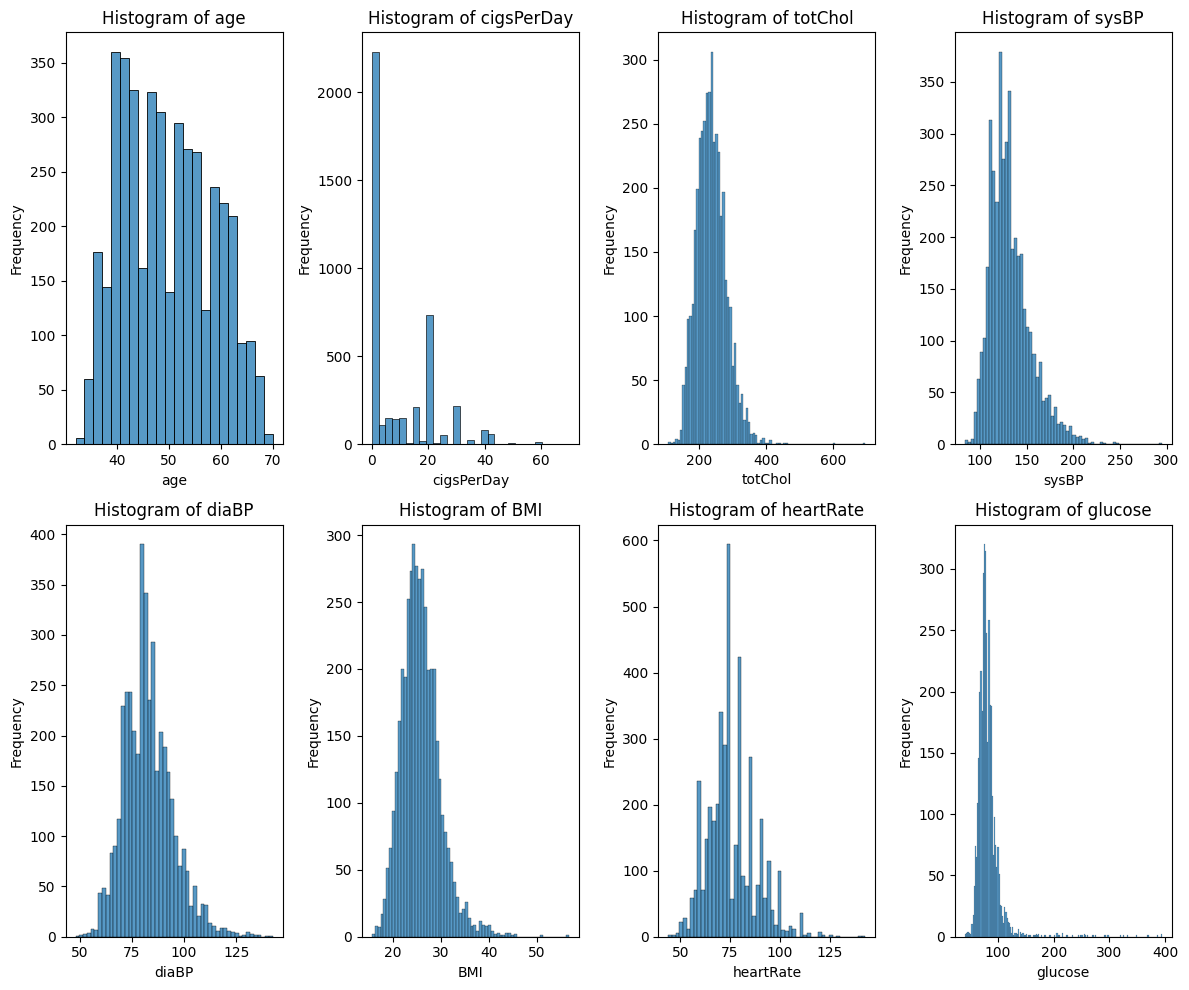

In [58]:
# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 4, figsize=(12, 10))  # Adjust size for better spacing

# Flatten the 2D array of axes to make indexing easier
axes = axes.flatten()

# Plot a histogram for each feature
for i, feature in enumerate(features):
    sns.histplot(continuous_data[feature], kde=False, ax=axes[i])  # Change bins for granularity
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
